In [ ]:
# Name : Shubham Sapkal
# Roll No. : 2012118
# subject: ML DL
# practical no. : 11 (A) & (B)

# Implementing CNN using Pytorch

* A Convolutional neural network (CNN) is a neural network that has one or more convolutional layers and are used mainly for **image processing, classification, segmentation and also for other auto correlated data.**
* CNN’s are deep neural network models that were originally designed to analyze 2D image input but can now also analyze 1D and 3D data.
* PyTorch is a very powerful framework for building deep learning.
* PyTorch is one of the most well-known and widely used deep learning libraries, particularly in academic research. 
* It’s an open-source machine learning framework that shortens the time it takes to go from research prototyping to production deployment. 
* This implementation will be divided into major steps such as data loading, model building, model training, and model testing.

PyTorch is one of the most well-known and widely used deep learning libraries, particularly in academic research. It’s an open-source machine learning framework that shortens the time it takes to go from research prototyping to production deployment. This implementation will be divided into major steps such as data loading, model building, model training, and model testing.

# Import all the dependencies

In [1]:
#import pytorch
import torch 
# access to some helpful neural network things, such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc).here,for fully-connected layers
import torch.nn as nn 
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.transforms import ToTensor
# plot graphs
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# Check device 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

 # Preparing the dataset

As discussed first we’ll load the dataset. The dataset we are using here is EMNIST which is an extended version of the MNIST dataset which contains handwritten digits along with small and capital handwritten letters. The training subset of this dataset contains nearly 1,20,000 images of size 28 x 28 pixels and those are in grayscale. We can load this dataset as train and test by specifying in the API itself.

Below first we have defined pre-processing functionality to the images and those to be applied in training and testing dataset when downloading. Later we have used the data loader which comes in handy especially in these cases where we are having thousands of images and loading all those at the time will keep our system under a tremendous burden. The data loader makes this dataset iterable and callable efficiently.      

In [4]:
# apply transformation
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])

# download the data
training_data = torchvision.datasets.EMNIST(root='contents/',download=True, transform=transform, train=True,split='balanced')
test_data = torchvision.datasets.EMNIST(root='contents/',download=True, transform=transform, train=False,split='balanced')

# build the data loader
train_loader = torch.utils.data.DataLoader(dataset = training_data,
                                           batch_size = 128,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                           batch_size = 128,
                                           shuffle = True)

In [5]:
training_data.data.shape

torch.Size([112800, 28, 28])

In [6]:
len(training_data.classes)

47

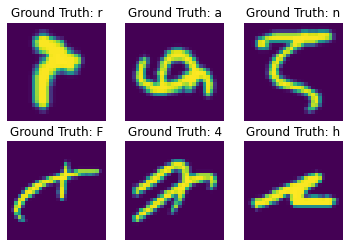

In [7]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(training_data.data[i])
  plt.title('Ground Truth: {}'.format(training_data.classes[training_data.targets[i]]))
  plt.axis('off')

Here are some of the samples of our dataset.

# Building the model

Next step comes for model definition. Here we’ll define our model like we define some sophisticated class in python. We can begin by creating a new class that makes use of PyTorch’s nn.Module class. This is essential when building a neural network because it provides us with a plethora of useful methods.

The layers of our neural network must then be defined. This is done in the class’s __init__ method. We can just simply name our layers and assign them to the appropriate layer, such as for this case a convolutional layer, a pooling layer, a fully connected layer, and so on.

Finally, in our class, we must define a forward method. The goal of this method is to specify the order in which the input data is processed by the various layers. Combinally all the above we can code it as,

In [8]:
# considered model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size= 5,stride = 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc = nn.Linear(64*20*20, 47)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

# initiating the model
model = CNNModel()

# Guidelines to be followed while building the model
When you look at the layer distribution and sizes of the units under the layer, you might think that we can pass it arbitrarily well, but that’s not the case. Even though I also tried to approach in that arbitrary way at the end I got an error for dimension miss-match. 

This error mainly arises between the connection of our convolutional layer and the Linear layer. In PyTorch, each layer takes the series of mandatory arguments in our case as shown for the convolutional layer:input_channels, output_channels, kernels, and optionally a stride. 

We can not set input channels arbitrarily but based on the type of our image whether it is grayscale / or B&W for that it should be 1 else for RGB image it should be 3. We can set the output size to any number and we should make this equal to the input of the next consecutive layer. Kernels are nothing but the filter which is used to create a feature map for a given image and stride basically tells the movement of the kernel over an image here 1 signifies it is taking 1 step at a time. 

So out of the above Linear layer expect two essential dimensions i.e. input and output shape. When we connect the convolutional layer to the Linear layer it accepts essentially the size of our image. And the last convolutional layer the dimension of our images has been changed to is now no longer 28 x 28 pixels. 

To get the proper value of input channels of the linear layer the calculation can be made as follows,

For the first layer, we have supplied a 28 x 28 image after applying 5 x 5 convolution pixels sizes are reduced by 4 on each side making 24 x 24 at output 1st layer.
Further, at the next layer, we have the same filter of 5 x 5 this will make it a further 20 x 20 and this is the batch size of the single image at output 2nd layer.
Now as we discussed the input channels for the linear layer should be 64*20*20. If you wish to increase the layers follow the kernel operation and get the appropriate batch size for fully connected layers.    

Now let’s come to the model definition, in the forward method we have applied the activation function to each layer after that we have applied a pooling operation where we have used max-pooling, and after we have flattened the layers. And lastly, in the forward pass, we have applied the softmax function which will turn out to be a classifier. 

# Compiling the model

Now in next, we’ll compile our model, here we mainly define the loss function and optimizer function. Here cross-entropy is used as a loss function and a Stochastic gradient descent optimizer is used to reduce loss in the training process. 

In [9]:
# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  

# Training, testing and evaluation procedure 

Next, we have built all the procedures and calculations. Now it’s time to train the above model. Training in PyTorch is a bit tricky here. We have to access each element manually and have to be arranged in a loop to make it continuous training. The procedure is as follows.

We begin by iterating through the number of epochs in our training data, followed by the batches. We convert the images and labels based on the device we’re using, whether it’s a GPU or a CPU. In the forward pass, we use our model to make predictions and then compute loss based on those predictions and our actual labels.

Following that, we perform a backward pass in which we update our weights in order to improve our model. The gradients are then set to zero before each update using the optimizer.zero grad() function. The new gradients are then calculated using the loss.backward() function.

Finally, we use the optimizer.step() function to update the weights.

In [10]:
# fetch model to the working device
model.to(device)

# training loss
train_loss = []
test_losses =[]
def train(e):
    #Load in the data 
    for i, (images, labels) in enumerate(train_loader):  
      # load data on to device
      images = images.to(device)
      labels = labels.to(device)
          
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
          
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_loss.append(loss.item())
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(e+1, 10, loss.item()))

Similarly, the testing technique is not dissimilar to the training procedure, with the exception of calculating the gradients because we are not updating any weights. We enclose the code with torch.no grad() because there is no need to calculate gradients. We next use our model to anticipate each batch and calculate how many of them are correct.

In [11]:
def test():
  test_loss = 0
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          test_loss += F.nll_loss(outputs, labels, size_average=False).item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      print('Test Accuracy: {:4f} %, Test loss: {:4f}'.format((100 * correct / total),test_loss))

We can start the training and testing simultaneously by using the two functions defined above. 

In [12]:
for i in range(10):
  train(i)
  test()

Epoch [1/10], Train Loss: 1.1428
Test Accuracy: 56.473404 %, Test loss: 1.543292
Epoch [2/10], Train Loss: 1.2066
Test Accuracy: 56.989362 %, Test loss: 1.515931
Epoch [3/10], Train Loss: 1.3632
Test Accuracy: 62.989362 %, Test loss: 1.313800
Epoch [4/10], Train Loss: 1.3434
Test Accuracy: 65.191489 %, Test loss: 1.220282
Epoch [5/10], Train Loss: 1.1305
Test Accuracy: 66.888298 %, Test loss: 1.171964
Epoch [6/10], Train Loss: 1.1108
Test Accuracy: 68.430851 %, Test loss: 1.083970
Epoch [7/10], Train Loss: 1.1863
Test Accuracy: 71.148936 %, Test loss: 1.036072
Epoch [8/10], Train Loss: 1.0374
Test Accuracy: 73.936170 %, Test loss: 0.905116
Epoch [9/10], Train Loss: 0.5901
Test Accuracy: 75.414894 %, Test loss: 0.832832
Epoch [10/10], Train Loss: 0.6874
Test Accuracy: 77.686170 %, Test loss: 0.769019


**This results in a testing accuracy of about 78%.since value is between 70% and 80%, we've got a good model.**

# legend plot- View Loss History

 A legend is an area describing the elements of the graph.

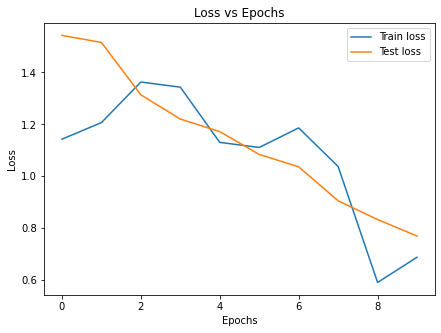

In [13]:
plt.figure(figsize=(7,5))
plt.plot(train_loss,label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Conclusion:
we have seen the working of convolutional neural network and we have implemented it practically using the PyTorch. If we compare this with other frameworks, PyTorch is built to be more developer-centric. To use PyTorch one should have a clear understanding of the application. In this case, we have developed CNN so that we should be able to trace the convolutional operation through the layers.